In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### READ IN DAILY DATA

In [2]:
states = pd.read_csv("./daily_data/nyt_states.csv")

counties = pd.read_csv("./daily_data/nyt_counties.csv")

testing = pd.read_csv("./daily_data/covid_tracking.csv")

## Prep County Data

In [3]:
counties["date"] = pd.to_datetime(counties.date, format = "%Y-%m-%d")

counties = counties.sort_values(by = ["county", "date" ]).reset_index(drop = True)

counties.head()

,date,county,state,fips,cases,deaths
0,2020-03-19,Abbeville,South Carolina,45001.0,1,0
1,2020-03-20,Abbeville,South Carolina,45001.0,1,0
2,2020-03-21,Abbeville,South Carolina,45001.0,1,0
3,2020-03-22,Abbeville,South Carolina,45001.0,1,0
4,2020-03-23,Abbeville,South Carolina,45001.0,1,0


In [4]:
unknown_indices = counties[counties.county == "Unknown"].index ## drop state level observations

counties = counties.drop(unknown_indices, axis = 0).reset_index(drop = True)

counties[counties.fips.isnull()].county.unique()

array(['Kansas City', 'New York City'], dtype=object)

In [5]:
kc_indices = counties[counties.county == "Kansas City"].index

ny_indices = counties[counties.county == "New York City"].index

for i in kc_indices:
    
    counties.at[i, "fips"] = -1 #assign non-null value so I can index through all counties by fips
                                #having an issue with shared county names
for j in ny_indices:
    
    counties.at[j, "fips"] = -2
    
#check my work
print(len(counties[counties.fips.isnull()]))

0


In [6]:
counties.head()

,date,county,state,fips,cases,deaths
0,2020-03-19,Abbeville,South Carolina,45001.0,1,0
1,2020-03-20,Abbeville,South Carolina,45001.0,1,0
2,2020-03-21,Abbeville,South Carolina,45001.0,1,0
3,2020-03-22,Abbeville,South Carolina,45001.0,1,0
4,2020-03-23,Abbeville,South Carolina,45001.0,1,0


In [7]:
county_frames = []

for cty in counties.fips.unique():
    
    county_df = counties[counties.fips == cty]
    
    county_df = county_df.sort_values(by = ["date"]).reset_index(drop = True) #ensure correct order
    
    if len(county_df) > 1:
        
        growth_rates = [0]
        
        for k in range(1, len(county_df)):
            
            growth_rates.append((county_df.iloc[k]["cases"] / county_df.iloc[k-1]["cases"]) - 1)
            
        growth_rates = pd.Series(growth_rates).rename("daily_growth_rate")
        
    else:
        
        growth_rates = pd.Series([-1]).rename("daily_growth_rate")
        
    assert len(growth_rates) == len(county_df)

    county_df = pd.concat([county_df, growth_rates], axis = 1)

    county_frames.append(county_df)

In [8]:
all_county = pd.concat(county_frames, axis = 0).reset_index(drop = True)

all_county.head()

,date,county,state,fips,cases,deaths,daily_growth_rate
0,2020-03-19,Abbeville,South Carolina,45001.0,1,0,0.0
1,2020-03-20,Abbeville,South Carolina,45001.0,1,0,0.0
2,2020-03-21,Abbeville,South Carolina,45001.0,1,0,0.0
3,2020-03-22,Abbeville,South Carolina,45001.0,1,0,0.0
4,2020-03-23,Abbeville,South Carolina,45001.0,1,0,0.0


In [9]:
del county_frames

del counties

## Prepare State Data

In [10]:
states["date"] = pd.to_datetime(states.date, format = "%Y-%m-%d")

states = states.sort_values(by = ["state", "date"]).reset_index(drop = True)

In [11]:
state_frames = []

for st in states.fips.unique():
    
    state_df = states[states.fips == st]
    
    state_df = state_df.sort_values(by = ["date"]).reset_index(drop = True) #ensure correct order
    
    if len(state_df) > 1:
        
        growth_rates = [0]
        
        for k in range(1, len(state_df)):
            
            growth_rates.append((state_df.iloc[k]["cases"] / state_df.iloc[k-1]["cases"]) - 1)
            
        growth_rates = pd.Series(growth_rates).rename("daily_growth_rate")
        
    else:
        
        growth_rates = pd.Series([-1]).rename("daily_growth_rate")
        
    assert len(growth_rates) == len(state_df)

    state_df = pd.concat([state_df, growth_rates], axis = 1)

    state_frames.append(state_df)
    
all_state = pd.concat(state_frames, axis = 0).reset_index(drop = True)

all_state.head()

,date,state,fips,cases,deaths,daily_growth_rate
0,2020-03-13,Alabama,1,6,0,0.000000
1,2020-03-14,Alabama,1,12,0,1.000000
2,2020-03-15,Alabama,1,23,0,0.916667
3,2020-03-16,Alabama,1,29,0,0.260870
4,2020-03-17,Alabama,1,39,0,0.344828


In [12]:
from IPython.display import display, HTML

In [13]:
def get_hot_counties(state: str, n_most = 10, all_county = all_county):
    
    state_df = all_county[all_county.state == state].reset_index(drop = True)
    
    hotspots = state_df[state_df.date == state_df.date.max()].sort_values(by = ["cases"], 
                                                                  ascending = False).county.values[:n_most]
    county_dfs = {}
    
    hot_counties = []
    
    for cty in hotspots:
        
        cty_df = state_df[state_df.county == cty].reset_index(drop = True)
        
        county_dfs[cty] = cty_df
        
        d = {}
        
        d["county"] = cty
        
        d["first_case"] = cty_df.date.min()
        
        d["total_cases"] = cty_df.iloc[-1]["cases"]
        
        d["previous_day_growth_rate"] = "{}%".format(
            round(cty_df.iloc[-1]["daily_growth_rate"] * 100, 2))
        
        if len(cty_df) >= 3:
            
            d["3day_avg_growth_rate"] = "{}%".format(
                round(cty_df.iloc[-1:-4:-1]["daily_growth_rate"].mean() * 100, 2))
            
        else:
            
            d["3day_avg_growth_rate"] = "Not Available"
            
        if len(cty_df) >= 7:
            
            d["7day_avg_growth_rate"] = "{}%".format(
                round(cty_df.iloc[-1:-8:-1]["daily_growth_rate"].mean() * 100, 2))
            
        else:
            
            d["7day_avg_growth_rate"] = "Not Available"
            
        hot_counties.append(d)
        
    summary_df = pd.DataFrame(hot_counties)
    
    print("The {} most effected counties in {}:".format(n_most, state))
    
    display(summary_df)
    
    return(county_dfs)
            
def analyze_state(state: str or int or float, all_county = all_county, all_state = all_state):
    
    if type(state) == str:
        
        state = state.capitalize()
        
        state_df = all_state[all_state.state == state].reset_index(drop = True)
        
        if len(state_df) == 0:
            
            state_df = all_state[all_state.state == state.reset_index(drop = True)]
            
            if len(state_df) == 0:
                
                raise NameError("Please ensure state name is spelled correctly")
                
    elif type(state) == int or type(state) == float:
        
        state_df = all_state[all_state.fips == state].reset_index(drop = True)
        
        if len(state_df) == 0:
            
            raise NameError("Please ensure correct FIPS entered")
            
    else:
        
        raise ValueError("Incorrect value passed to state. Please enter state name or state FIPS code")
        
    state_name = state_df.iloc[0]["state"]
    
    if len(state_df) == 1:
        
        return("{} recorded its first case of COVID-19 on {}, with {} total cases".format(
        state_name, state_df.iloc[-1]["date"], state_df.iloc[-1]["cases"]))
    
    else:
        
        print("{} reported its first cases of COVID-19 on {}, and has {} cases as of {}\n".format(
        state_name, state_df.date.min(), state_df.iloc[-1]["cases"], 
        state_df.date.max()))
        
        print("The previous daily growth rate was {}%\n".format(
            round(state_df.iloc[-1]["daily_growth_rate"] * 100, 2) ))
        
        if len(state_df) >= 3:
            
            _3day = state_df.iloc[-1:-4:-1].daily_growth_rate.mean()
            
            print("The 3 day average growth rate was {}%\n".format(
            round(_3day * 100, 2)))
            
        if len(state_df) >= 7:
            
            _7day = state_df.iloc[-1:-8:-1].daily_growth_rate.mean()
            
            print("The 7 day average growth rate was {}%\n".format(
            round(_7day * 100, 2)))
            
        c = get_hot_counties(state_name)
            
        fig, ax = plt.subplots(4, figsize = (15, 25))
        
        ax[0].scatter(state_df.date, state_df.cases, c = "k")
        
        ax[0].plot(state_df.date, state_df.cases)
        
        ax[0].set_title("Total Cases - {}".format(state_name), weight = "bold")
        
        ax[0].set_ylabel("Total Number of Cases", weight = "bold")
        
        ax[0].set_xlabel("Date", weight = "bold")
        
        ax[1].scatter(state_df.date, state_df.daily_growth_rate * 100, c = "k")
        
        ax[1].plot(state_df.date, state_df.daily_growth_rate * 100)
        
        ax[1].set_title("Daily Growth Rate - {}".format(state_name), weight = "bold")
        
        ax[1].set_ylabel("Percentage Growth (Case Numbers) from Previous Day", weight = "bold")
        
        ax[1].set_xlabel("Date", weight = "bold")
        
        for cty in c:
            
            ax[2].plot(c[cty].date, c[cty].cases, label = cty)
            
            ax[2].text(c[cty].iloc[-1]["date"], c[cty].iloc[-1]["cases"], c[cty].iloc[-1]["cases"],
                        horizontalalignment='left', weight = "bold")
            
            ax[3].plot(c[cty].date, c[cty].daily_growth_rate * 100, label = cty)
        
        ax[2].legend(bbox_to_anchor=(0.00, 1), loc='upper left', borderaxespad=0)
        
        ax[2].set_title("Cases by County - {}".format(state_name), weight = "bold")
        
        ax[2].set_ylabel("Number of Cases", weight = "bold")
        
        ax[2].set_xlabel("Date", weight = "bold")
        
        ax[3].legend(bbox_to_anchor=(0.00, 1), loc = "upper left", borderaxespad=0)
        
        ax[3].set_title("Daily Growth Rate by County - {}".format(state_name), weight = "bold")
        
        ax[3].set_ylabel("Percentage Growth (Caase Numbers) from Previous Day", weight = "bold")
        
        ax[3].set_xlabel("Date", weight = "bold")

California reported its first cases of COVID-19 on 2020-01-25 00:00:00, and has 12569 cases as of 2020-04-03 00:00:00

The previous daily growth rate was 14.32%

The 3 day average growth rate was 13.57%

The 7 day average growth rate was 14.38%

The 10 most effected counties in California:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,Los Angeles,2020-01-26,4566,12.88%,14.9%,17.68%
1,San Diego,2020-02-10,1112,15.11%,14.85%,15.12%
2,Santa Clara,2020-01-31,1094,14.44%,7.28%,10.05%
3,Orange,2020-01-25,711,17.33%,12.68%,12.59%
4,Riverside,2020-03-07,638,29.41%,20.77%,20.63%
5,San Francisco,2020-02-02,500,11.11%,7.78%,8.56%
6,San Mateo,2020-03-02,486,7.28%,16.53%,10.99%
7,Alameda,2020-03-01,464,11.27%,11.59%,9.87%
8,Sacramento,2020-02-21,389,14.41%,20.96%,14.21%
9,San Bernardino,2020-03-15,353,16.12%,24.87%,30.41%


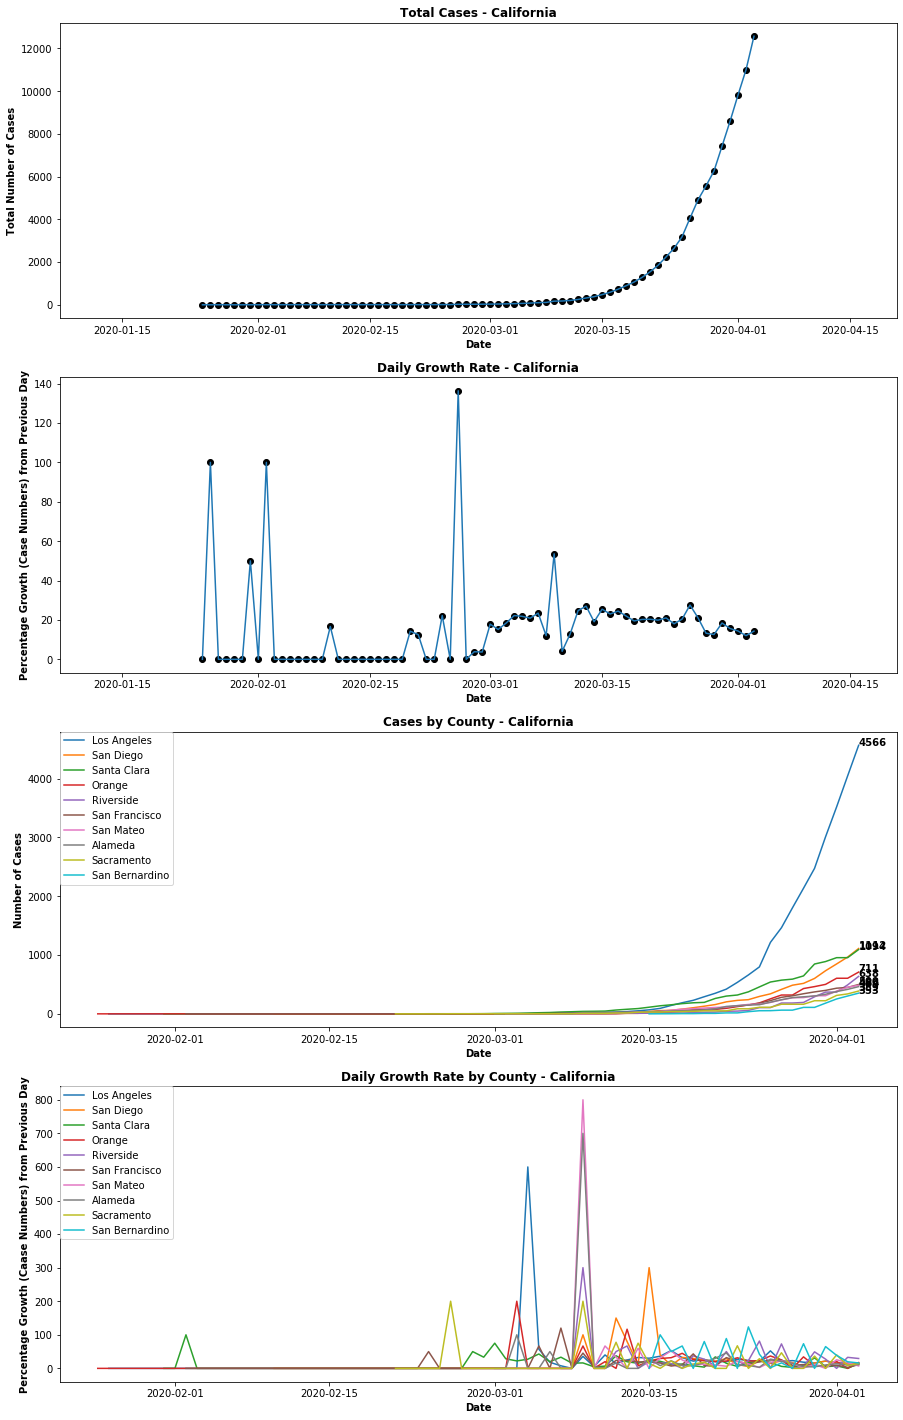

In [14]:
analyze_state("California")

Colorado reported its first cases of COVID-19 on 2020-03-05 00:00:00, and has 4182 cases as of 2020-04-03 00:00:00

The previous daily growth rate was 12.18%

The 3 day average growth rate was 11.83%

The 7 day average growth rate was 13.42%

The 10 most effected counties in Colorado:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,Denver,2020-03-06,716,11.35%,9.93%,12.64%
1,Arapahoe,2020-03-09,500,13.38%,12.66%,18.45%
2,Jefferson,2020-03-05,440,14.29%,13.18%,15.81%
3,Weld,2020-03-13,379,15.2%,14.13%,16.72%
4,El Paso,2020-03-06,374,10.0%,9.36%,12.94%
5,Eagle,2020-03-06,333,6.05%,14.15%,10.39%
6,Adams,2020-03-12,294,13.08%,16.75%,22.84%
7,Douglas,2020-03-05,194,13.45%,10.47%,13.77%
8,Boulder,2020-03-14,143,8.33%,10.22%,9.49%
9,Larimer,2020-03-09,134,8.06%,10.68%,10.49%


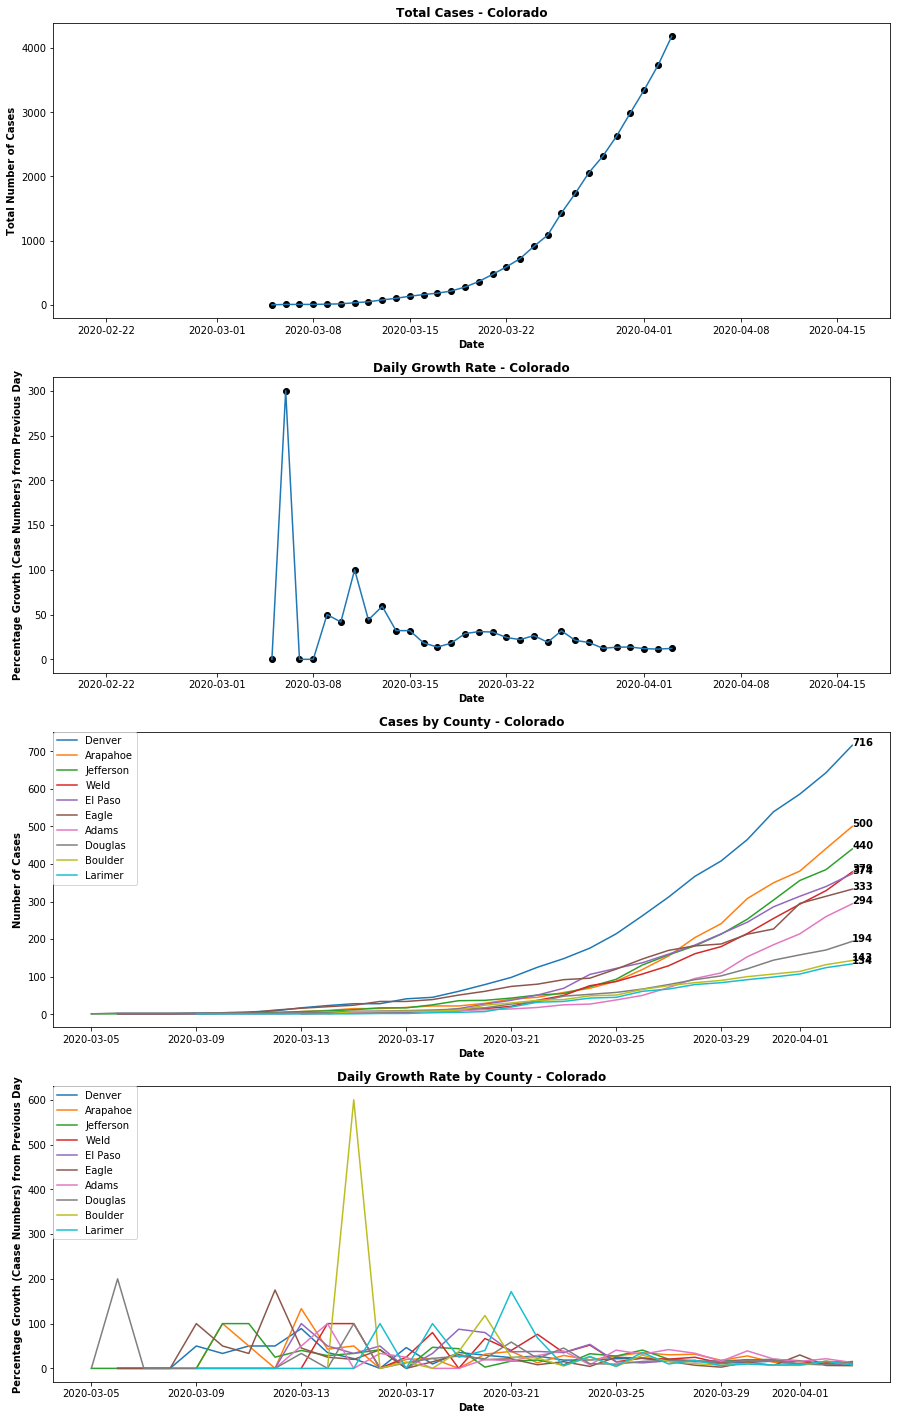

In [15]:
analyze_state("Colorado")

Illinois reported its first cases of COVID-19 on 2020-01-24 00:00:00, and has 8904 cases as of 2020-04-03 00:00:00

The previous daily growth rate was 15.71%

The 3 day average growth rate was 14.13%

The 7 day average growth rate was 16.81%

The 10 most effected counties in Illinois:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,Cook,2020-01-24,6473,16.11%,12.97%,16.61%
1,Lake,2020-03-11,608,12.59%,16.14%,14.94%
2,DuPage,2020-03-14,500,11.61%,12.0%,14.46%
3,Will,2020-03-16,455,18.49%,26.32%,24.36%
4,Kane,2020-03-10,176,14.29%,11.22%,12.56%
5,McHenry,2020-03-10,102,25.93%,17.61%,12.73%
6,Kankakee,2020-03-18,68,15.25%,13.35%,23.33%
7,St. Clair,2020-03-14,57,3.64%,10.22%,22.64%
8,Champaign,2020-03-22,51,18.6%,25.28%,26.91%
9,Kendall,2020-03-18,37,2.78%,26.07%,25.38%


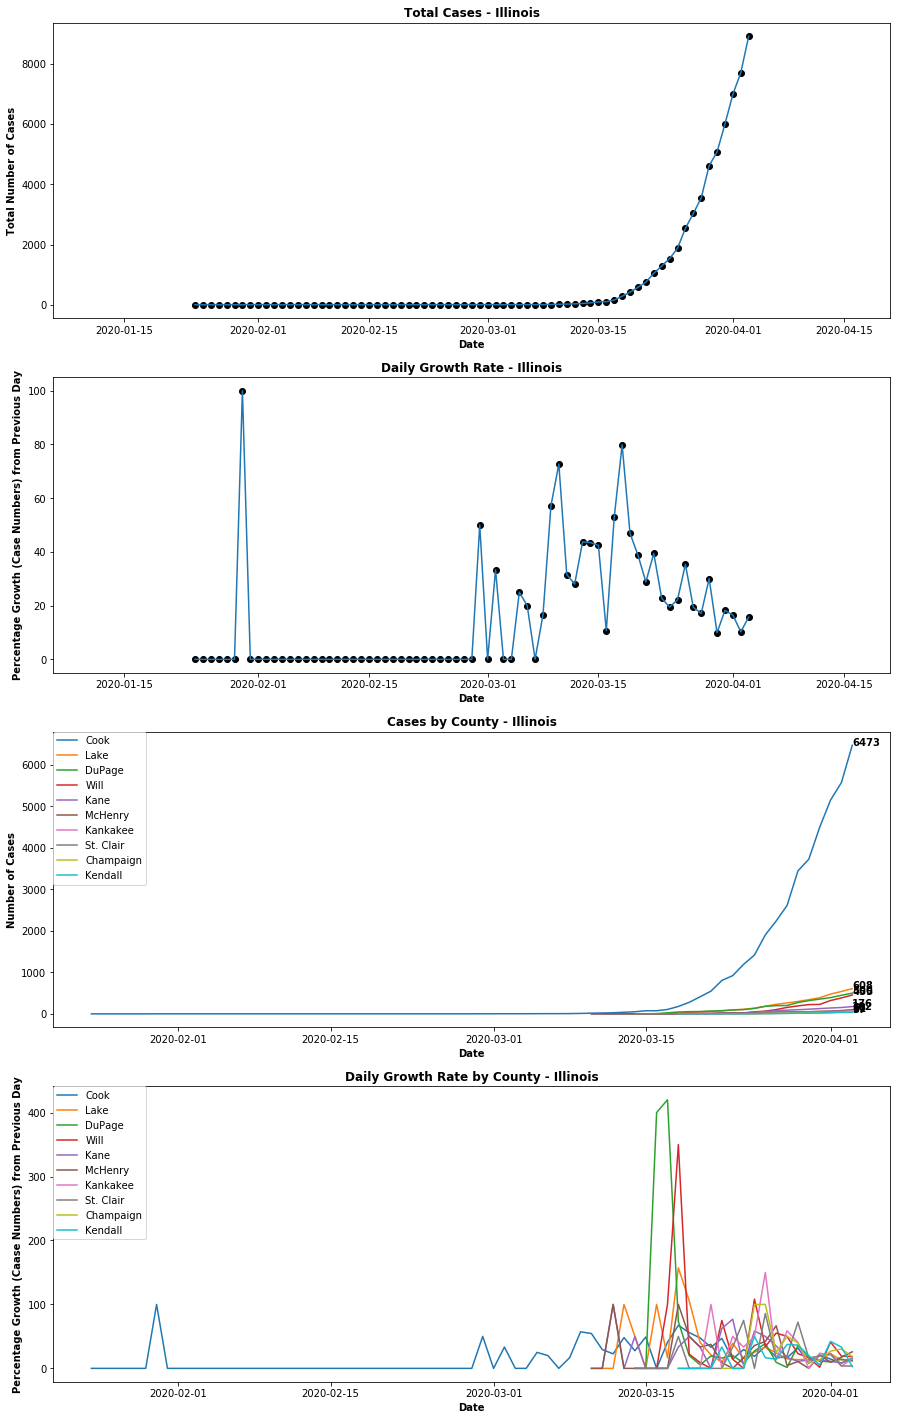

In [16]:
analyze_state("Illinois")

### GET N COUNTIES WITH MOST ACTIVE CASES

In [17]:
def get_most(county, n):
    
    most_recent = county[county.date == county.date.max()]
    
    hotspots = most_recent.sort_values(by = ["cases"], ascending = False).iloc[:n].fips
    
    fig, ax = plt.subplots(figsize = (15, 8))
    
    for cty in hotspots:
        
        county_dates = county[county.fips == cty].date
        
        county_cases = county[county.fips == cty].cases
        
        ax.scatter(county_dates, county_cases)

        ax.plot(county_dates, county_cases, label = county[county.fips == cty].county.max())
        
        ax.text(county_dates.iloc[-1], county_cases.iloc[-1], county_cases.iloc[-1],
                        horizontalalignment='left', weight = "bold")
        
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    ax.set_title("{} Counties With Most Cases".format(n), weight = "bold")

    ax.set_xlabel("Date", weight = "bold")

    ax.set_ylabel("Number of Cases", weight = "bold");

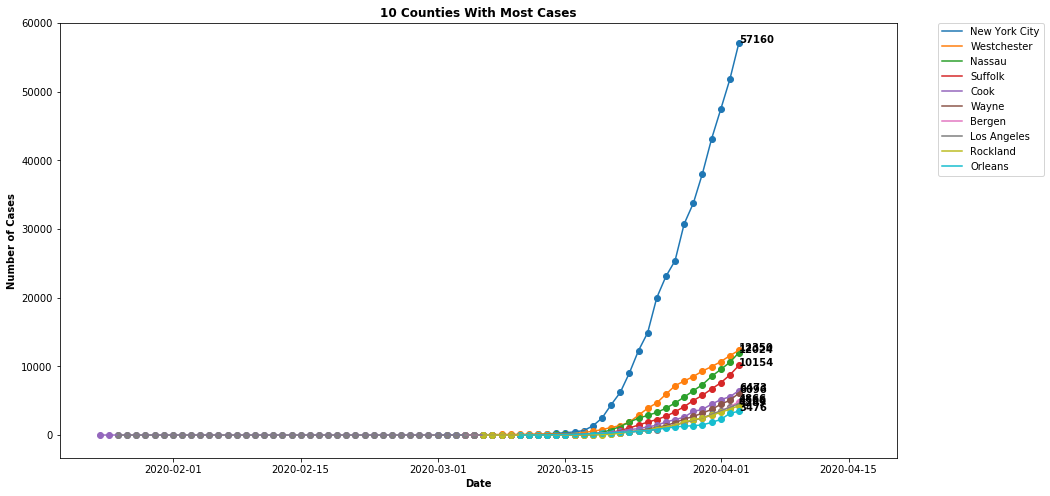

In [18]:
get_most(all_county, 10)

### EXPLORING TESTING DATA- COURTESY OF COVID TRACKING PROJECT

In [19]:
testing.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200403,AK,157.0,5859.0,NaN,NaN,15.0,NaN,NaN,NaN,...,15.0,6016,6016,6016,2,0.0,6.0,980.0,14.0,994.0
1,20200403,AL,1432.0,8187.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9619,9619,9619,1,3.0,0.0,684.0,199.0,883.0
2,20200403,AR,704.0,8995.0,NaN,71.0,NaN,NaN,NaN,26.0,...,NaN,9699,9699,9699,5,0.0,0.0,1115.0,61.0,1176.0
3,20200403,AS,NaN,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,26,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200403,AZ,1769.0,22904.0,NaN,NaN,249.0,NaN,91.0,NaN,...,249.0,24673,24673,24673,4,9.0,21.0,1793.0,171.0,1964.0


In [20]:
testing["date"] = pd.to_datetime(testing.date, format = "%Y%m%d")

testing = testing.sort_values(by = ["state", "date"]).reset_index(drop = True)

In [21]:
pd.set_option("max.columns", 50)

testing.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-03-06,AK,0.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b95ff00414e9a5542ba2aa08fdfda0b023c7c69c,2020-03-06T21:00:00Z,NaN,NaN,9,8,8,2,NaN,NaN,NaN,NaN,NaN
1,2020-03-07,AK,0.0,12.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71953eb42494f6000afda41cda80b1b3dc836a83,2020-03-07T21:00:00Z,NaN,NaN,14,12,12,2,0.0,0.0,4.0,0.0,4.0
2,2020-03-08,AK,0.0,14.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,844624448b0ee3ff7dd240e0d3f4258de1563064,2020-03-08T20:00:00Z,NaN,NaN,20,14,14,2,0.0,0.0,2.0,0.0,2.0
3,2020-03-09,AK,0.0,23.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b5cbe627dd51a6e70136134185391030f93ffcb5,2020-03-09T20:00:00Z,NaN,NaN,32,23,23,2,0.0,0.0,9.0,0.0,9.0
4,2020-03-10,AK,0.0,23.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6561feac0f53ef762911b4995038df195c62b2cb,2020-03-10T20:00:00Z,NaN,NaN,32,23,23,2,0.0,0.0,0.0,0.0,0.0


### Positive Result Rate: The ratio of n_positive / n_negative

In [22]:
def positive_test_rate(st: str or list, data = testing):
    
    fig, ax = plt.subplots(figsize = (15, 8))
    
    if type(st) == str:
    
        if len(state) > 2:

            raise ValueError("Please pass two digit state code")

        state_testing = testing[testing.state == st].reset_index(drop = True)

        print("NOTE: THIS IS THE RATIO OF POSITIVE TESTS TO TEST RESULTS... PENDING TESTS ARE NOT\
         ACCOUNTED FOR AS THE DATA IS NOT COMPLETE")

        ax.plot(state_testing.date, (state_testing.positive / state_testing.totalTestResults) * 100, 
                c = "r", label = "Pos/Neg Ratio")

        ax.text(state_testing.date.max(), 
                (state_testing.iloc[-1]["positive"] / state_testing.iloc[-1]["totalTestResults"]) * 100,
                "{}%".format(round(
                    (state_testing.iloc[-1]["positive"] / state_testing.iloc[-1]["totalTestResults"]) * 100,
                                  2)), horizontalalignment = "left", verticalalignment = "center", c = "b", size = 11)

        ax.grid(True)

        ax.set_title("Ratio of Confirmed Positive to Total Test Results - {}".format(state), 
                     weight = "bold", size = 15)

        ax.set_xlabel("Date", weight = "bold", size = 12)

        ax.set_ylabel("Percentage of Positive Tests", weight = "bold",
                     size = 12);
        
    else:
        
        print("NOTE: THIS IS THE RATIO OF POSITIVE TESTS TO TEST RESULTS... PENDING TESTS ARE NOT\
             ACCOUNTED FOR AS THE DATA IS NOT COMPLETE")
        
        for state in st:
            
            if len(state) > 2:

                raise ValueError("Please pass two digit state code")

            state_testing = testing[testing.state == state].reset_index(drop = True)

            ax.plot(state_testing.date, (state_testing.positive / state_testing.totalTestResults) * 100, 
                    label = state)

            ax.text(state_testing.date.max(), 
                    (state_testing.iloc[-1]["positive"] / state_testing.iloc[-1]["totalTestResults"]) * 100,
                    "{}%".format(
                        round((state_testing.iloc[-1]["positive"] / state_testing.iloc[-1]["totalTestResults"]) * 100,
                                      2)), horizontalalignment = "left", verticalalignment = "center", c = "b", size = 11)

            ax.grid(True)

        ax.set_title("Ratio of Confirmed Positive to Total Test Results", 
                     weight = "bold", size = 15)

        ax.set_xlabel("Date", weight = "bold", size = 12)

        ax.set_ylabel("Percentage of Positive Tests", weight = "bold",
                         size = 12)
        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0); 

NOTE: THIS IS THE RATIO OF POSITIVE TESTS TO TEST RESULTS... PENDING TESTS ARE NOT             ACCOUNTED FOR AS THE DATA IS NOT COMPLETE


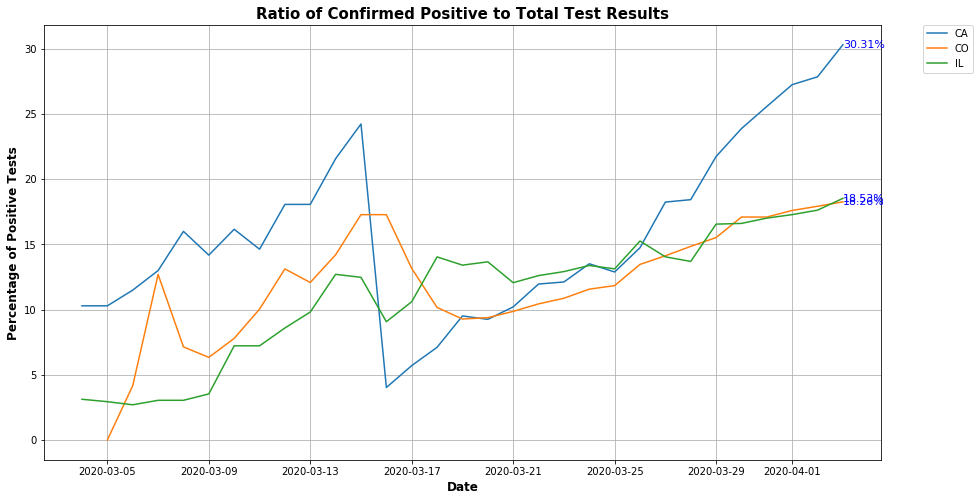

In [23]:
positive_test_rate(["CA", "CO", "IL"])

## Percentage of Positive/Total Test (CONFIRMED RESULTS) V. MORTALITY RATE- DEFINED AS NUMBER OF COVID DEATHS / NUMBER OF CONFIRMED POSITIVE RESULTS

In [24]:
z = np.polyfit(most_recent.pos_ratio * 100, most_recent.mortality_rate * 100, 1)

p = np.poly1d(z)

ax.plot(most_recent.pos_ratio * 100, p(most_recent.pos_ratio * 100), ls = "--", c = "r")

NameError: name 'most_recent' is not defined

In [25]:
def pos_v_mort(data = testing):
    
    most_recent = data[data.date == data.date.max()].reset_index(drop = True)
    
    territories = ["VI", "AS", "MP", "GU", "PR"]

    drop_indices = []

    for k in range(len(most_recent)):

        if most_recent.iloc[k]["state"] in territories:

            drop_indices.append(k)
            
    most_recent = most_recent.drop(drop_indices, axis = 0).reset_index(drop = True)
    
    most_recent["pos_ratio"] = most_recent.positive / most_recent.totalTestResults

    ##I am defining death rate as: number of COVID deaths / number of positive test results
    most_recent["mortality_rate"] = most_recent.death / most_recent.positive

    fig, ax = plt.subplots(figsize = (10, 10))

    color_scheme = np.where(most_recent.pos_ratio > most_recent.pos_ratio.mean(), 'red', 'blue')

    ax.set_facecolor("xkcd:off white")

    ax.scatter(most_recent.pos_ratio * 100, most_recent.mortality_rate * 100, c = color_scheme, edgecolor = "w")

    ax.axvline(most_recent.pos_ratio.mean() * 100, c = "k", ls = "--", alpha = 0.5)

    ax.axhline(most_recent.mortality_rate.mean() * 100, c = "k", ls = "--", alpha = 0.5)
    
    z = np.polyfit(most_recent.pos_ratio * 100, most_recent.mortality_rate * 100, 1)

    p = np.poly1d(z)

    ax.plot(most_recent.pos_ratio * 100, p(most_recent.pos_ratio * 100), ls = "-", c = "k", alpha = 0.5)

    for i, state in enumerate(most_recent.state.values):

        ax.annotate(state, (most_recent.pos_ratio.values[i] * 100, most_recent.mortality_rate.values[i] * 100))

    text_box = {

                "boxstyle" : "square",

                "facecolor" : "xkcd:powder blue",

                "edgecolor" : "k",

                "alpha" : 0.75
            }

    text = "\n".join((
        "Avg Positive Test Rate: {}%".format(round(most_recent.pos_ratio.mean()*100, 2)),
        "Avg Mortality Rate: {}%".format(round(most_recent.mortality_rate.mean()*100, 2))
    ))

    ax.grid(True, alpha = 0.25)

    ax.text(0.99, 0.99, text, transform = ax.transAxes, fontsize = 12, horizontalalignment = "right",
            verticalalignment = "top", bbox = text_box)

    ax.set_title("Ratio of Positive Tests v. Mortality Rate - {}".format(most_recent.date.max()), weight = "bold",
                size = 12)

    ax.set_xlabel("Percentage of Positive Tests", weight = "bold", size = 12)

    ax.set_ylabel("Mortality Rate (%)", weight = "bold", size = 12);

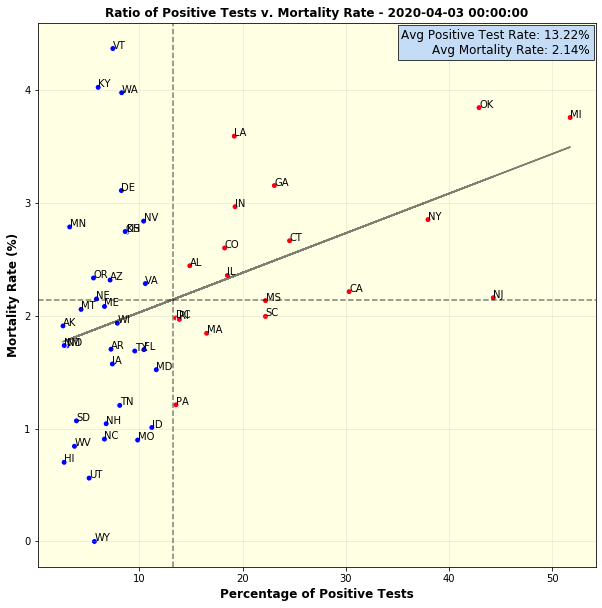

In [26]:
pos_v_mort()